In [20]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [22]:
mnist.target = mnist.target.astype(np.int8) 
sort_by_target(mnist)
x, y = mnist["data"], mnist["target"]
x.shape

(70000, 784)

In [9]:
y.shape

(70000,)

In [21]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [23]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]
import numpy as np
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

In [24]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [25]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
sgd_clf.predict([x[50]])

array([False])

In [42]:
# implementation of cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index, in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9666
0.96235
0.9618


In [43]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.9666 , 0.96235, 0.9618 ])

In [45]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x),1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.9115 , 0.909  , 0.90845])

In [46]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)


In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53897,   682],
       [ 1503,  3918]])

In [48]:
#precision:  TP / TP + FP
#recall: TP / TP + FN

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8517391304347826
0.7227448810182623


In [49]:
#F1 = 2 / (1/precision) + (1/recall) = TP / (TP+(FN+FP/2)) = harmonic mean
# Model gets a high F1 if it has good precision and recall

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.781957888434288

In [50]:
some_digit = [x[50]]
y_scores = sgd_clf.decision_function(some_digit)
y_scores

array([-20745.01550797])

In [55]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [54]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [56]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3, method = "decision_function")

In [57]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [1]:
import matplotlib
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(thresholds, precisions[:-1], "b--", label= "precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [59]:
y_train_pred_90 = (y_scores > 70000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.0
0.0


/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


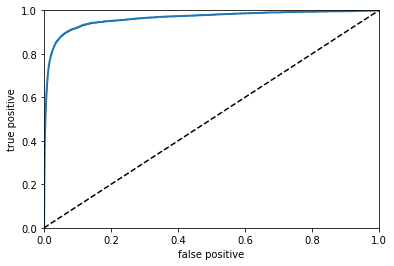

In [60]:
# receiver operating characteristic, plots TP vs FP, recall vs specificity
# we want the to left corner to be as high as possible without moving to the right and getting FP
# measuring ROC AUC (area under curve), auc = 1 means a perfect classifier, auc = 0.5 means it's essentially random

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.ylabel('true positive')
    plt.xlabel('false positive')
plot_roc_curve(fpr, tpr)
plt.show()

In [61]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9632290075072439

/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


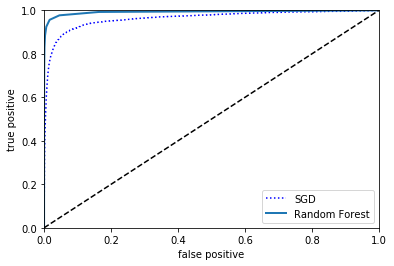

In [63]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [68]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict(some_digit)

array([0], dtype=int8)

In [66]:
some_digit

[array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

In [69]:
some_digit_scores = sgd_clf.decision_function(some_digit)
some_digit_scores

array([[ 12359.66126605, -56931.03112353,  -8864.44372098,
        -17792.55735177, -17478.26760143,  -9480.90028078,
        -25422.24615926, -12972.01046552, -15729.30202027,
        -12595.22258547]])

In [70]:
np.argmax(some_digit_scores)

0

In [71]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict(some_digit)

array([0], dtype=int8)

In [72]:
len(ovo_clf.estimators_)

45

In [73]:
forest_clf.fit(x_train, y_train)
forest_clf.predict(some_digit)

/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0], dtype=int8)

In [74]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87612478, 0.88554428, 0.84177627])

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90371926, 0.9079954 , 0.90313547])

In [76]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


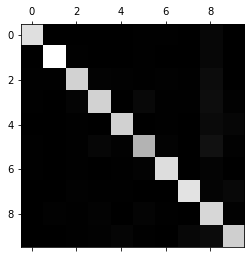

In [77]:
# confusion matrix, the diagonals are correct classifications, ie 5's classified as 5's

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [78]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

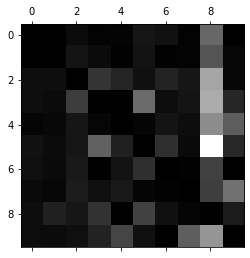

In [79]:
# this shows the errors, notice how 8's are bright
# need to train on more 8 data, or add some anti-8 bias

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [80]:
# multilabel classification with KNN

from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [81]:
knn_clf.predict(some_digit)

array([[False, False]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
noise = np.random.randint(0,100,(len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0,100,(len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

In [ ]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test])
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
plot_digit(clean_digit)